<a href="https://colab.research.google.com/github/yomyaykya/yomyay/blob/master/MMO_DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline
sns.set(style="ticks")

In [ ]:
data_loaded = pd.read_csv('solar.csv', sep=",")

In [ ]:
data_loaded.head()

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Unnamed: 6,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunaltitude,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,1.0,NaN,3:14:51,46438.0,49456.0,5.0,NaN,0.2701,1.0733,NaN,NaN,74.0,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,2.0,NaN,23:45:23,46426.0,49457.0,10.0,NaN,0.2702,0.9382,NaN,NaN,76.0,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,3.0,NaN,18:09:16,46415.0,49458.0,15.0,NaN,0.2703,1.0284,NaN,NaN,60.0,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,4.0,NaN,5:57:03,46403.0,49459.0,20.0,NaN,0.2704,0.9806,NaN,NaN,25.0,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,5.0,NaN,13:19:56,46393.0,49460.0,-13.0,NaN,0.2705,0.1611,NaN,NaN,0.0,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00


In [ ]:
data_loaded.shape

(32686, 19)

In [ ]:
data_loaded = data_loaded.drop(['Unnamed: 6', 'Sunaltitude'], axis=1)
data_loaded.head()

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,1.0,NaN,3:14:51,46438.0,49456.0,5.0,0.2701,1.0733,NaN,NaN,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,2.0,NaN,23:45:23,46426.0,49457.0,10.0,0.2702,0.9382,NaN,NaN,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,3.0,NaN,18:09:16,46415.0,49458.0,15.0,0.2703,1.0284,NaN,NaN,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,4.0,NaN,5:57:03,46403.0,49459.0,20.0,0.2704,0.9806,NaN,NaN,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,5.0,NaN,13:19:56,46393.0,49460.0,-13.0,0.2705,0.1611,NaN,NaN,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00


In [ ]:
def check_null_values(data):
    return list(zip([i for i in data.columns], zip(
    #типы колонок
    [str(i) for i in data.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in data.isnull().sum()])))

In [ ]:
data_features = check_null_values(data_loaded)
data_features

[('Catalog Number', ('float64', 20788)),
 ('Unnamed: 1', ('float64', 32686)),
 ('Time', ('object', 20788)),
 ('Delta', ('float64', 20788)),
 ('Lunationnumber', ('float64', 20788)),
 ('Sarosnumber', ('float64', 20788)),
 ('Gamma', ('float64', 20788)),
 ('Eclipsemagnitude', ('float64', 20788)),
 ('Unnamed: 9', ('float64', 32686)),
 ('Unnamed: 10', ('float64', 32686)),
 ('Sunazimuth', ('float64', 20788)),
 ('PathWidth (km)', ('float64', 20835)),
 ('Central Duration', ('object', 19672)),
 ('UNIXTime', ('int64', 0)),
 ('WindDirection(Degrees)', ('float64', 0)),
 ('TimeSunRise', ('object', 0)),
 ('TimeSunSet', ('object', 0))]

**Устранение пропусков в данных**

**Заполнение значений для одного признака**

In [ ]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [ ]:
check_null_values(data_na_replaced)

[('Catalog Number', ('float64', 0)),
 ('Unnamed: 1', ('float64', 32686)),
 ('Time', ('object', 20788)),
 ('Delta', ('float64', 20788)),
 ('Lunationnumber', ('float64', 20788)),
 ('Sarosnumber', ('float64', 20788)),
 ('Gamma', ('float64', 20788)),
 ('Eclipsemagnitude', ('float64', 20788)),
 ('Unnamed: 9', ('float64', 32686)),
 ('Unnamed: 10', ('float64', 32686)),
 ('Sunazimuth', ('float64', 20788)),
 ('PathWidth (km)', ('float64', 20835)),
 ('Central Duration', ('object', 19672)),
 ('UNIXTime', ('int64', 0)),
 ('WindDirection(Degrees)', ('float64', 0)),
 ('TimeSunRise', ('object', 0)),
 ('TimeSunSet', ('object', 0))]

In [ ]:
data_na_replaced

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,1.0,NaN,3:14:51,46438.0,49456.0,5.0,0.2701,1.0733,NaN,NaN,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,2.0,NaN,23:45:23,46426.0,49457.0,10.0,0.2702,0.9382,NaN,NaN,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,3.0,NaN,18:09:16,46415.0,49458.0,15.0,0.2703,1.0284,NaN,NaN,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,4.0,NaN,5:57:03,46403.0,49459.0,20.0,0.2704,0.9806,NaN,NaN,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,5.0,NaN,13:19:56,46393.0,49460.0,-13.0,0.2705,0.1611,NaN,NaN,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587604,145.42,6:41:00,17:42:00
32682,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587301,117.78,6:41:00,17:42:00
32683,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587001,145.19,6:41:00,17:42:00
32684,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480586702,164.19,6:41:00,17:42:00


In [ ]:
data_loaded['Delta']

0        46438.0
1        46426.0
2        46415.0
3        46403.0
4        46393.0
          ...   
32681        NaN
32682        NaN
32683        NaN
32684        NaN
32685        NaN
Name: Delta, Length: 32686, dtype: float64

In [ ]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

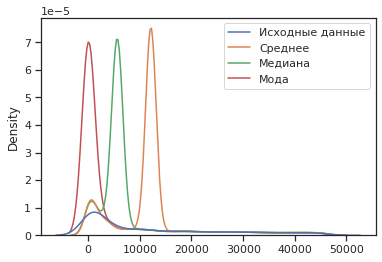

In [ ]:
#Сравнение заполнения различными показателями распределения
research_impute_numeric_column(data_loaded, 'Delta')

**Кодирование категориальных признаков**

**1. Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
data_encoded = data_na_replaced.copy()
data_encoded

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,1.0,NaN,3:14:51,46438.0,49456.0,5.0,0.2701,1.0733,NaN,NaN,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,2.0,NaN,23:45:23,46426.0,49457.0,10.0,0.2702,0.9382,NaN,NaN,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,3.0,NaN,18:09:16,46415.0,49458.0,15.0,0.2703,1.0284,NaN,NaN,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,4.0,NaN,5:57:03,46403.0,49459.0,20.0,0.2704,0.9806,NaN,NaN,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,5.0,NaN,13:19:56,46393.0,49460.0,-13.0,0.2705,0.1611,NaN,NaN,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587604,145.42,6:41:00,17:42:00
32682,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587301,117.78,6:41:00,17:42:00
32683,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480587001,145.19,6:41:00,17:42:00
32684,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480586702,164.19,6:41:00,17:42:00


In [ ]:
#le = LabelEncoder()
category_columns = ['Catalog Number', 'Delta', 'Gamma']
for col in category_columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
data_encoded

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,0,NaN,3:14:51,9189,49456.0,5.0,0,1.0733,NaN,NaN,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,1,NaN,23:45:23,9188,49457.0,10.0,1,0.9382,NaN,NaN,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,2,NaN,18:09:16,9187,49458.0,15.0,2,1.0284,NaN,NaN,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,3,NaN,5:57:03,9186,49459.0,20.0,3,0.9806,NaN,NaN,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,4,NaN,13:19:56,9185,49460.0,-13.0,4,0.1611,NaN,NaN,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,0,NaN,NaN,16113,NaN,NaN,17019,NaN,NaN,NaN,NaN,NaN,NaN,1480587604,145.42,6:41:00,17:42:00
32682,0,NaN,NaN,16112,NaN,NaN,17018,NaN,NaN,NaN,NaN,NaN,NaN,1480587301,117.78,6:41:00,17:42:00
32683,0,NaN,NaN,9190,NaN,NaN,17017,NaN,NaN,NaN,NaN,NaN,NaN,1480587001,145.19,6:41:00,17:42:00
32684,0,NaN,NaN,21876,NaN,NaN,22780,NaN,NaN,NaN,NaN,NaN,NaN,1480586702,164.19,6:41:00,17:42:00


**Нормализация числовых признаков**

In [ ]:
import scipy.stats as stats

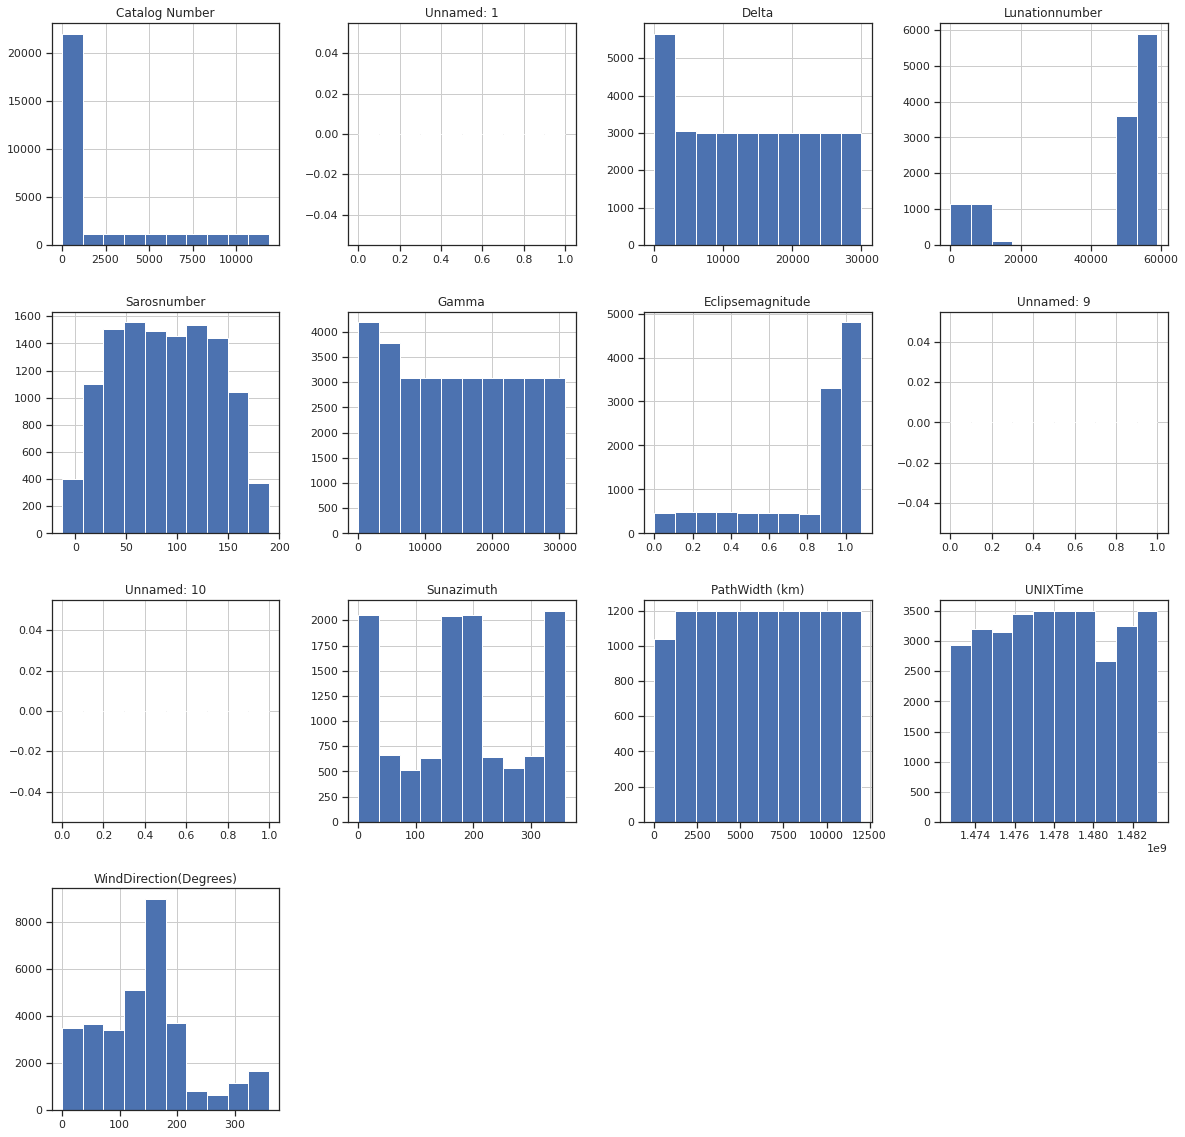

In [ ]:
data_encoded.hist(figsize=(20, 20))
plt.show()

In [ ]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

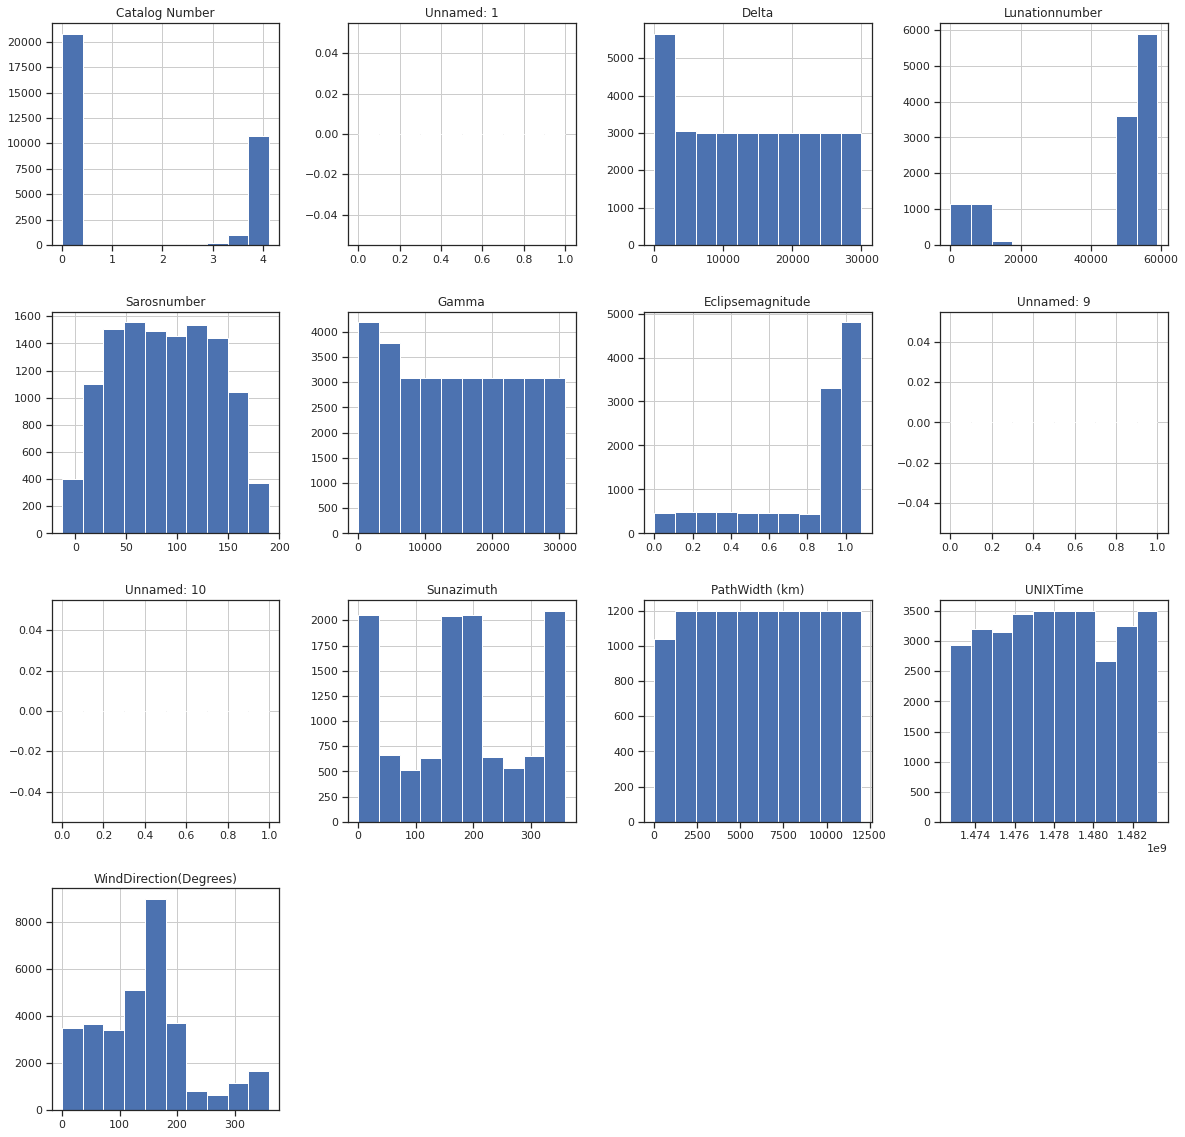

In [ ]:
data_normalized.hist(figsize=(20,20))
plt.show()

In [ ]:
data_normalized

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,-0.000000,NaN,3:14:51,9189,49456.0,5.0,0,1.0733,NaN,NaN,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,0.645487,NaN,23:45:23,9188,49457.0,10.0,1,0.9382,NaN,NaN,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,0.982104,NaN,18:09:16,9187,49458.0,15.0,2,1.0284,NaN,NaN,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,1.204290,NaN,5:57:03,9186,49459.0,20.0,3,0.9806,NaN,NaN,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,1.367702,NaN,13:19:56,9185,49460.0,-13.0,4,0.1611,NaN,NaN,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,-0.000000,NaN,NaN,16113,NaN,NaN,17019,NaN,NaN,NaN,NaN,NaN,NaN,1480587604,145.42,6:41:00,17:42:00
32682,-0.000000,NaN,NaN,16112,NaN,NaN,17018,NaN,NaN,NaN,NaN,NaN,NaN,1480587301,117.78,6:41:00,17:42:00
32683,-0.000000,NaN,NaN,9190,NaN,NaN,17017,NaN,NaN,NaN,NaN,NaN,NaN,1480587001,145.19,6:41:00,17:42:00
32684,-0.000000,NaN,NaN,21876,NaN,NaN,22780,NaN,NaN,NaN,NaN,NaN,NaN,1480586702,164.19,6:41:00,17:42:00


**Масштабирование признаков**

**На основе Z-оценки**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
cols_to_scale = ['Delta',	'Gamma','Lunationnumber',	'Sarosnumber']
data_to_scale = data_loaded[cols_to_scale]
data_to_scale = data_to_scale.dropna()
data_to_scale.describe()

,Delta,Gamma,Lunationnumber,Sarosnumber
count,11898.000000,11898.000000,11898.000000,11898.000000
mean,12142.172802,0.742000,44567.074971,87.483190
std,13583.402888,0.280094,19443.399140,48.380284
min,-6.000000,0.270100,1.000000,-13.000000
25%,970.250000,0.518025,50038.250000,47.000000
50%,5636.500000,0.684550,53012.500000,87.000000
75%,20943.500000,0.981975,55986.750000,128.000000
max,46438.000000,1.279400,58961.000000,190.000000


In [ ]:
X_ALL = data_to_scale.drop('Gamma', axis=1)
X_ALL

,Delta,Lunationnumber,Sarosnumber
0,46438.0,49456.0,5.0
1,46426.0,49457.0,10.0
2,46415.0,49458.0,15.0
3,46403.0,49459.0,20.0
4,46393.0,49460.0,-13.0
...,...,...,...
11893,4414.0,12355.0,187.0
11894,4417.0,12360.0,154.0
11895,4420.0,12366.0,159.0
11896,4424.0,12372.0,164.0


In [ ]:
# Функция восстановления датафрейма на основе масштабированных данных 
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=X_ALL.columns)
    return res

In [ ]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, data_to_scale['Gamma'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape

((9518, 3), (2380, 3))

In [ ]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,Delta,Lunationnumber,Sarosnumber
0,2.524939,0.251455,-1.704964
1,2.524056,0.251506,-1.601612
2,2.523246,0.251557,-1.498260
3,2.522363,0.251609,-1.394908
4,2.521626,0.251660,-2.077032
...,...,...,...
11893,-0.568966,-1.656780,2.057057
11894,-0.568745,-1.656523,1.374932
11895,-0.568525,-1.656214,1.478284
11896,-0.568230,-1.655905,1.581637


In [ ]:
# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

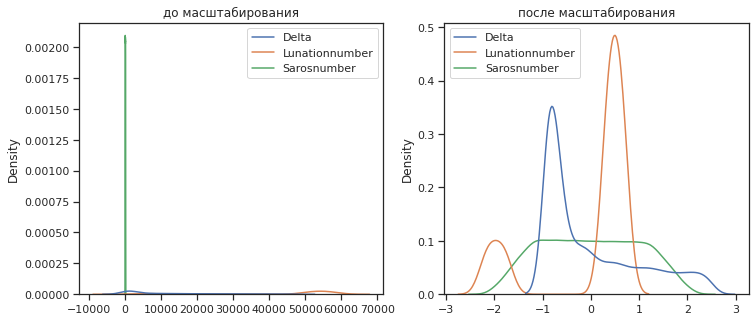

In [ ]:
draw_kde(['Delta', 'Lunationnumber', 'Sarosnumber'], data_to_scale, data_cs11_scaled,
         'до масштабирования', 'после масштабирования')

**Обработка выбросов**

In [ ]:
x_col_list = ['Delta', 'Sarosnumber', 'Lunationnumber']

In [ ]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

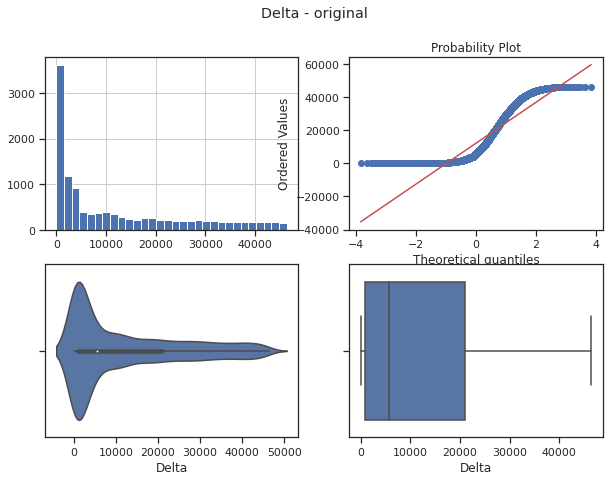

In [ ]:
diagnostic_plots(data_to_scale, 'Delta', 'Delta - original')

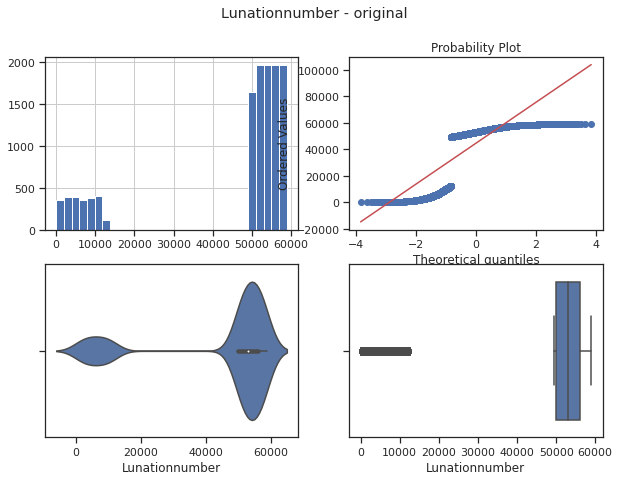

In [ ]:
diagnostic_plots(data_to_scale, 'Lunationnumber', 'Lunationnumber - original')

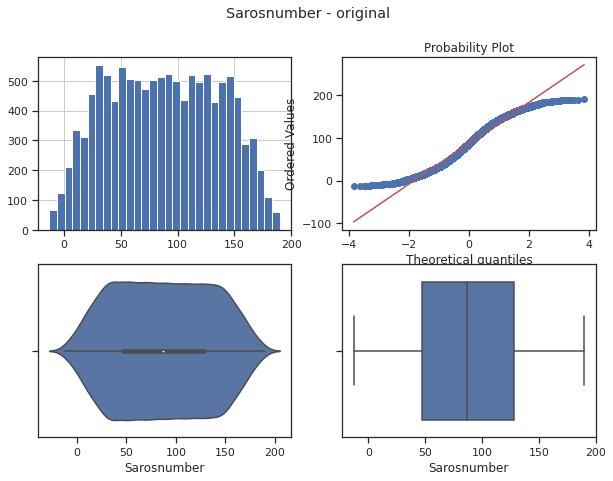

In [ ]:
diagnostic_plots(data_to_scale, 'Sarosnumber', 'Sarosnumber - original')

In [ ]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

In [ ]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary

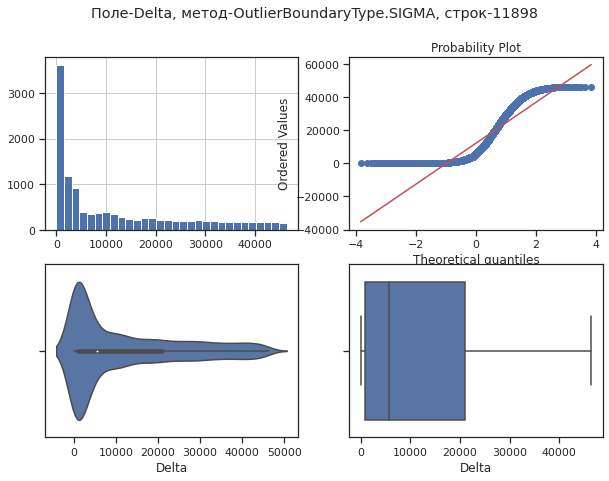

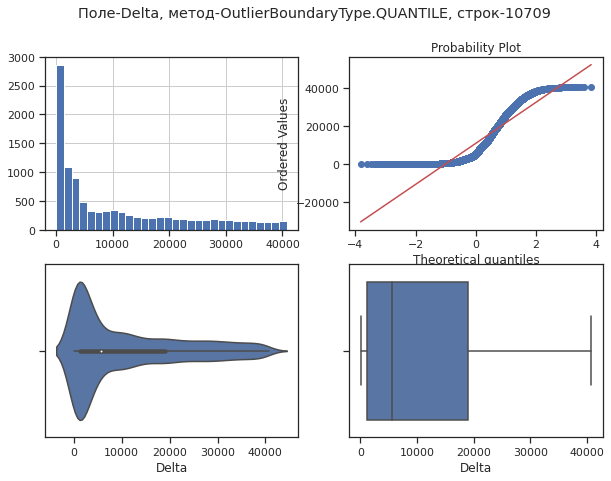

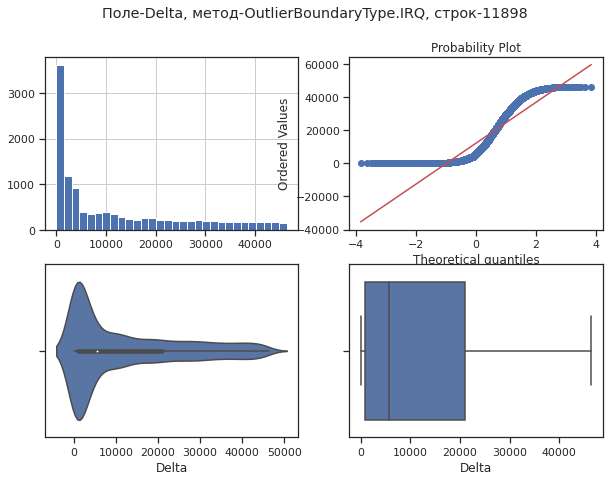

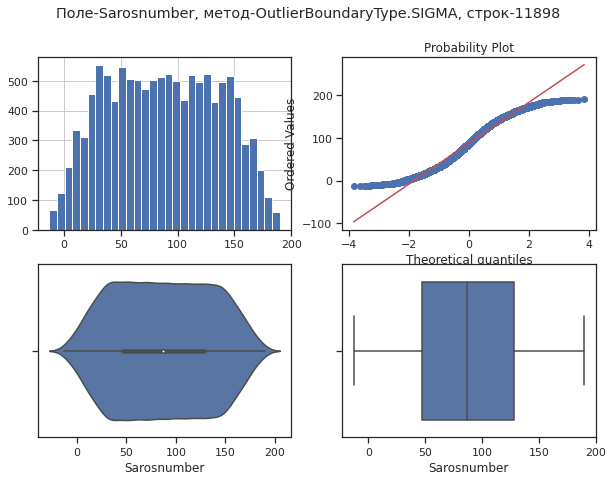

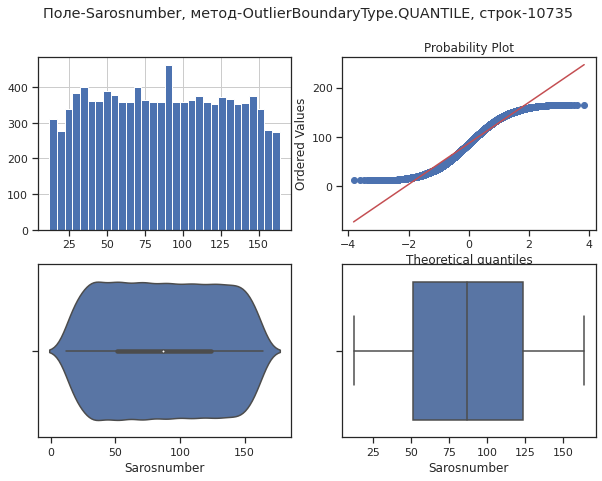

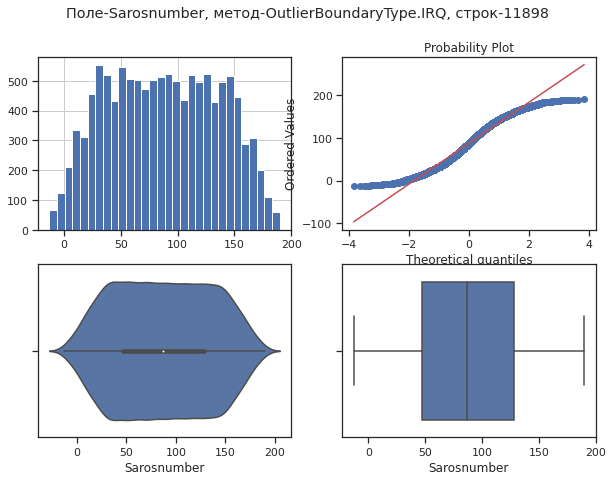

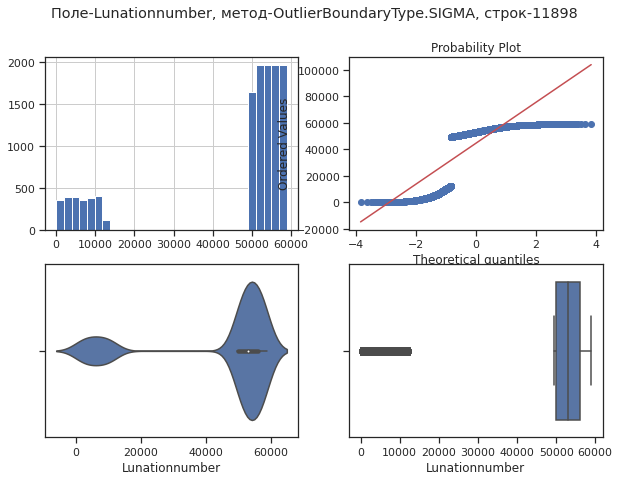

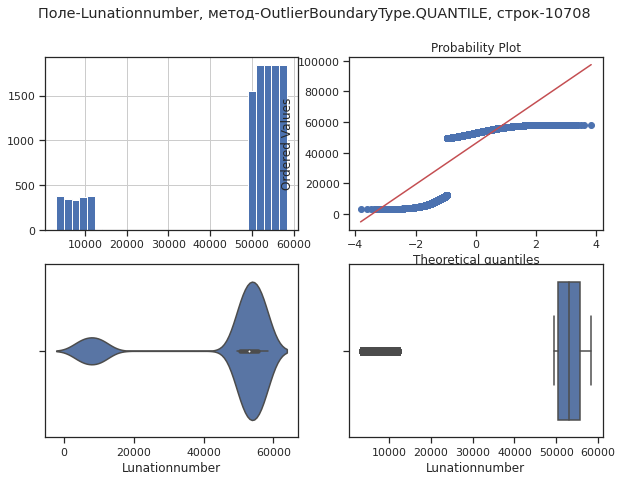

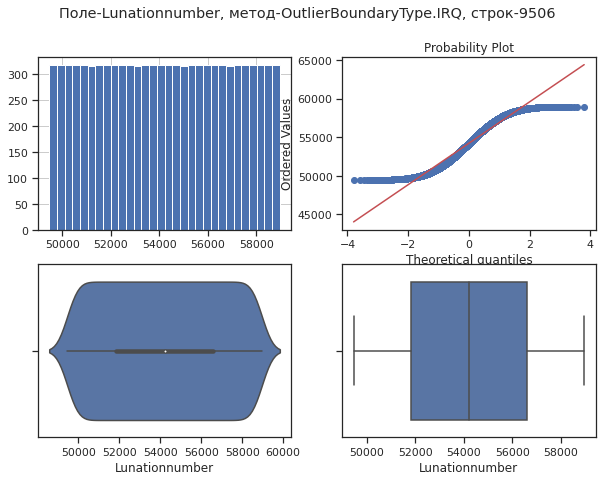

In [ ]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(data_to_scale[col] > upper_boundary, True, 
                                 np.where(data_to_scale[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = data_to_scale.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

**Замена выбросов**

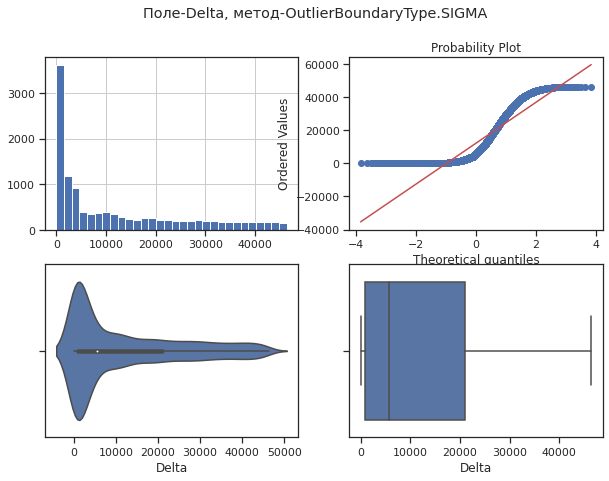

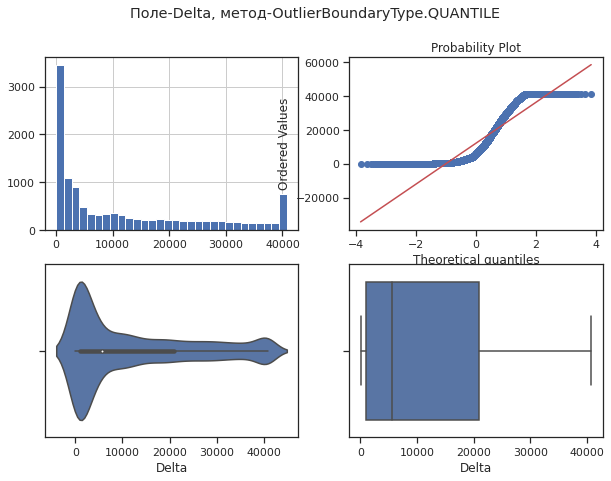

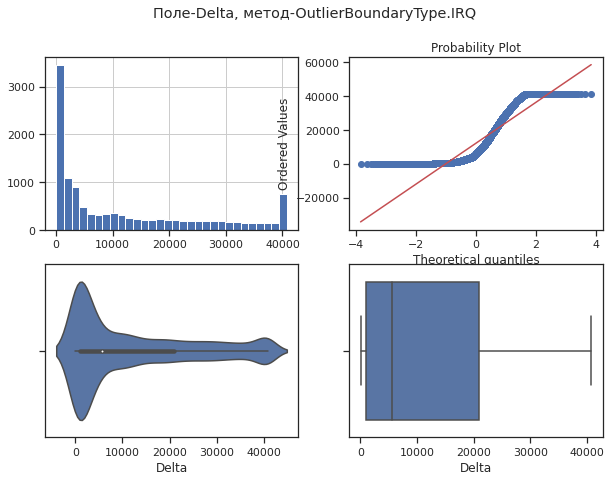

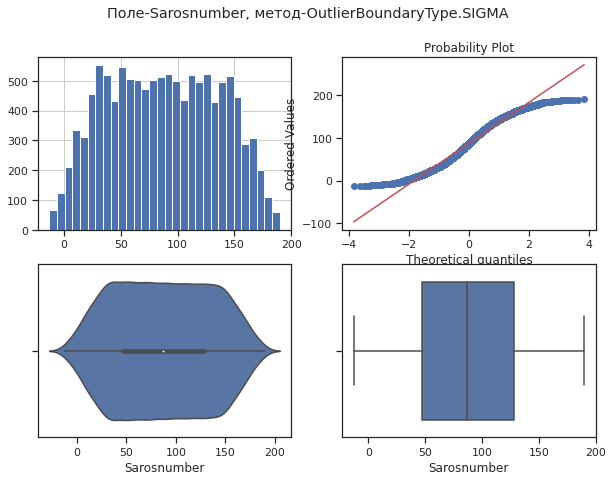

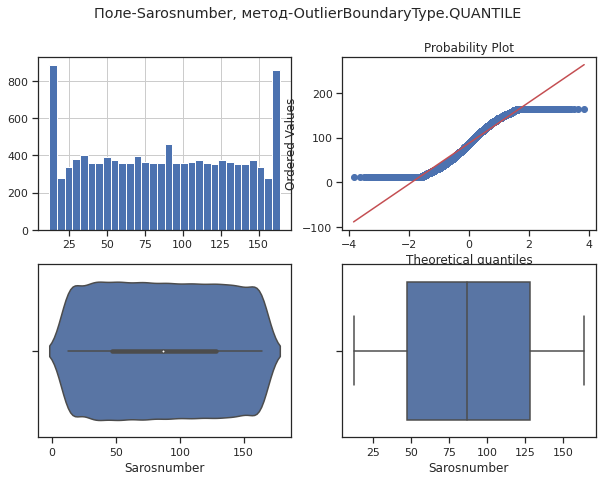

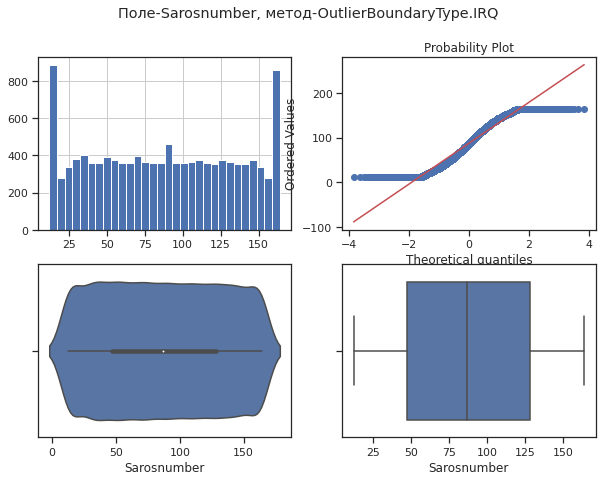

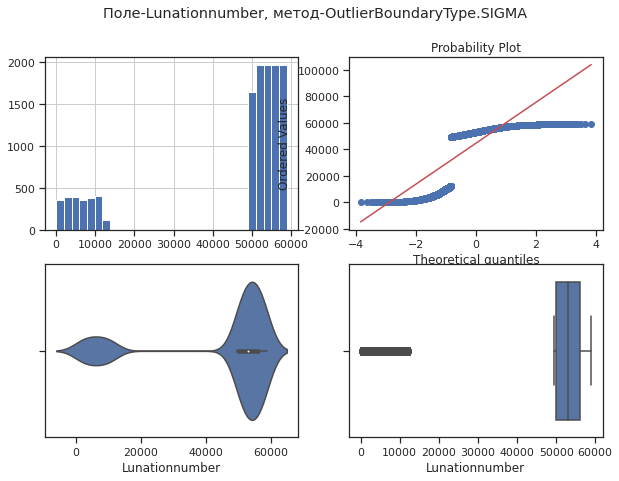

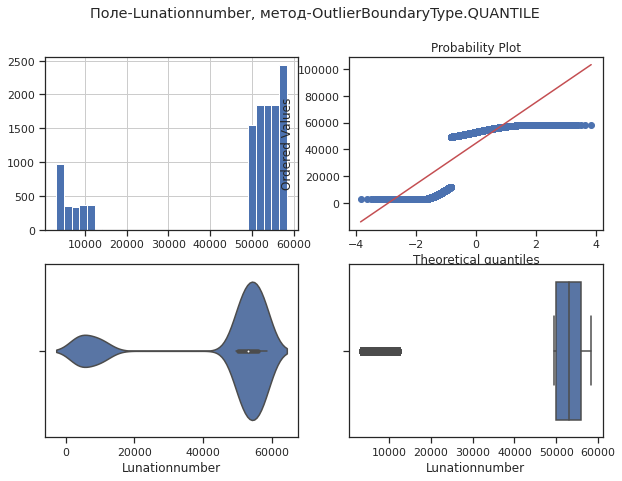

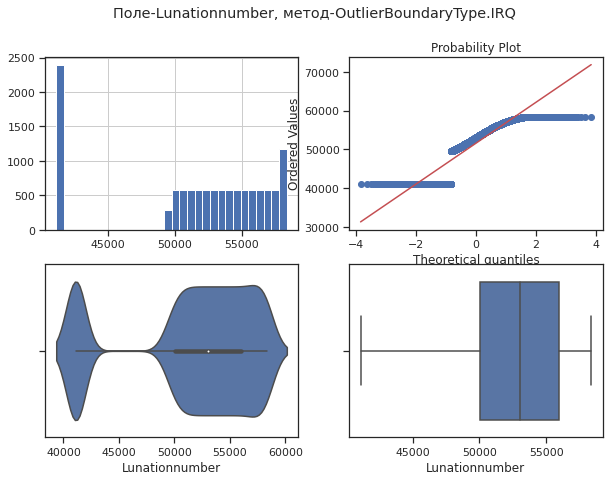

In [ ]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data_to_scale, col, obt)
        # Изменение данных
        data_to_scale[col] = np.where(data_to_scale[col] > upper_boundary, upper_boundary, 
                                 np.where(data_to_scale[col] < lower_boundary, lower_boundary, data_to_scale[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data_to_scale, col, title)

In [ ]:
data_outliers_deleted

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,-0.000000,NaN,3:14:51,9189,49456.0,5.0,0,1.0733,NaN,NaN,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,0.645487,NaN,23:45:23,9188,49457.0,10.0,1,0.9382,NaN,NaN,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,0.982104,NaN,18:09:16,9187,49458.0,15.0,2,1.0284,NaN,NaN,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,1.204290,NaN,5:57:03,9186,49459.0,20.0,3,0.9806,NaN,NaN,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,1.367702,NaN,13:19:56,9185,49460.0,-13.0,4,0.1611,NaN,NaN,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,-0.000000,NaN,NaN,16113,NaN,NaN,17019,NaN,NaN,NaN,NaN,NaN,NaN,1480587604,145.42,6:41:00,17:42:00
32682,-0.000000,NaN,NaN,16112,NaN,NaN,17018,NaN,NaN,NaN,NaN,NaN,NaN,1480587301,117.78,6:41:00,17:42:00
32683,-0.000000,NaN,NaN,9190,NaN,NaN,17017,NaN,NaN,NaN,NaN,NaN,NaN,1480587001,145.19,6:41:00,17:42:00
32684,-0.000000,NaN,NaN,21876,NaN,NaN,22780,NaN,NaN,NaN,NaN,NaN,NaN,1480586702,164.19,6:41:00,17:42:00


**Отбор признаков**

**Метод фильтрации** 

**Метод, основынный на корреляции**

In [ ]:
cols_to_fs = ['Catalog Number',		'Delta',	'Lunationnumber',	'Sarosnumber',	
              'UNIXTime',]
fs_data = data_loaded[cols_to_fs].copy()
fs_data.shape

(32686, 5)

In [ ]:
fs_data_features = list(zip(
[i for i in fs_data.columns],
zip(
    #типы колонок
    [str(i) for i in fs_data.dtypes],
    #проверка, есть ли пропущенные значения
    [i for i in fs_data.isnull().sum()]
)))
fs_data_features

[('Catalog Number', ('float64', 20788)),
 ('Delta', ('float64', 20788)),
 ('Lunationnumber', ('float64', 20788)),
 ('Sarosnumber', ('float64', 20788)),
 ('UNIXTime', ('int64', 0))]

In [ ]:
fs_data.tail()

,Catalog Number,Delta,Lunationnumber,Sarosnumber,UNIXTime
32681,NaN,NaN,NaN,NaN,1480587604
32682,NaN,NaN,NaN,NaN,1480587301
32683,NaN,NaN,NaN,NaN,1480587001
32684,NaN,NaN,NaN,NaN,1480586702
32685,NaN,NaN,NaN,NaN,1480586402


In [ ]:
fs_data = fs_data.dropna()
fs_data.shape

(11898, 5)

In [ ]:
g_cat_enc_le = le.fit_transform(fs_data['UNIXTime'])
g_cat_enc_le

array([7416, 7415, 7414, ..., 7419, 7418, 7417])

In [ ]:
fs_data['UNIXTime'] = g_cat_enc_le
fs_data['UNIXTime']

0        7416
1        7415
2        7414
3        7413
4        7412
         ... 
11893    7421
11894    7420
11895    7419
11896    7418
11897    7417
Name: UNIXTime, Length: 11898, dtype: int64

In [ ]:
fs_data

,Catalog Number,Delta,Lunationnumber,Sarosnumber,UNIXTime
0,1.0,46438.0,49456.0,5.0,7416
1,2.0,46426.0,49457.0,10.0,7415
2,3.0,46415.0,49458.0,15.0,7414
3,4.0,46403.0,49459.0,20.0,7413
4,5.0,46393.0,49460.0,-13.0,7412
...,...,...,...,...,...
11893,11894.0,4414.0,12355.0,187.0,7421
11894,11895.0,4417.0,12360.0,154.0,7420
11895,11896.0,4420.0,12366.0,159.0,7419
11896,11897.0,4424.0,12372.0,164.0,7418


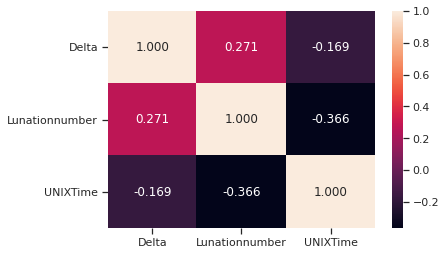

In [ ]:
heatmap_cols = [ 'Delta', 'Lunationnumber', 'UNIXTime', ]
sns.heatmap(fs_data[heatmap_cols].corr(), annot=True, fmt='.3f')

In [ ]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr() # !!!вот здесь был недочет - data.corr -> df.corr
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.3]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [ ]:
make_corr_df(fs_data)

,f1,f2,corr
0,Sarosnumber,Catalog Number,0.965515
1,Catalog Number,Sarosnumber,0.965515
2,Catalog Number,Delta,0.896787
3,Delta,Catalog Number,0.896787
4,Delta,Sarosnumber,0.862184
5,Sarosnumber,Delta,0.862184
6,Catalog Number,Lunationnumber,0.588694
7,Lunationnumber,Catalog Number,0.588694
8,Lunationnumber,Sarosnumber,0.572768
9,Sarosnumber,Lunationnumber,0.572768


In [ ]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [ ]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(fs_data))

[['Catalog Number', 'Delta', 'Lunationnumber', 'UNIXTime', 'Sarosnumber']]

**Метод, основанный на статистических характеристиках**

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
x = fs_data.drop('UNIXTime', axis=1)
x

,Catalog Number,Delta,Lunationnumber,Sarosnumber
0,1.0,46438.0,49456.0,5.0
1,2.0,46426.0,49457.0,10.0
2,3.0,46415.0,49458.0,15.0
3,4.0,46403.0,49459.0,20.0
4,5.0,46393.0,49460.0,-13.0
...,...,...,...,...
11893,11894.0,4414.0,12355.0,187.0
11894,11895.0,4417.0,12360.0,154.0
11895,11896.0,4420.0,12366.0,159.0
11896,11897.0,4424.0,12372.0,164.0


In [ ]:
y = fs_data['UNIXTime']
y

0        7416
1        7415
2        7414
3        7413
4        7412
         ... 
11893    7421
11894    7420
11895    7419
11896    7418
11897    7417
Name: UNIXTime, Length: 11898, dtype: int64

Text(0, 0.5, 'Взаимная информация')

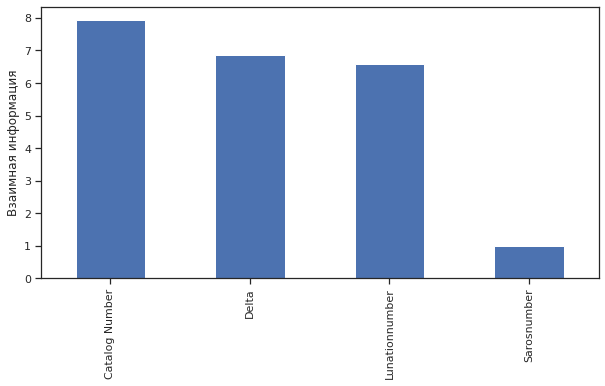

In [ ]:
mi = mutual_info_regression(x, y)
mi = pd.Series(mi)
mi.index = x.columns
mi.sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.ylabel('Взаимная информация')

**Обучение моделей с различными вариантами масштабирования признаков**

In [ ]:
data_encoded['UNIXTime']

0        1475229326
1        1475229023
2        1475228726
3        1475228421
4        1475228124
            ...    
32681    1480587604
32682    1480587301
32683    1480587001
32684    1480586702
32685    1480586402
Name: UNIXTime, Length: 32686, dtype: int64

In [ ]:
# данные с выпдоненными 1-4 пунктами предобработки 
#(устранение пропусков в данных, кодирование категориальных признаков, нормализацию числовых признаков, 
#масштабирование признаков
data_cs11_scaled

,Delta,Lunationnumber,Sarosnumber
0,2.524939,0.251455,-1.704964
1,2.524056,0.251506,-1.601612
2,2.523246,0.251557,-1.498260
3,2.522363,0.251609,-1.394908
4,2.521626,0.251660,-2.077032
...,...,...,...
11893,-0.568966,-1.656780,2.057057
11894,-0.568745,-1.656523,1.374932
11895,-0.568525,-1.656214,1.478284
11896,-0.568230,-1.655905,1.581637


In [ ]:
# данные, с замененными выбросами
data_outliers_deleted

,Catalog Number,Unnamed: 1,Time,Delta,Lunationnumber,Sarosnumber,Gamma,Eclipsemagnitude,Unnamed: 9,Unnamed: 10,Sunazimuth,PathWidth (km),Central Duration,UNIXTime,WindDirection(Degrees),TimeSunRise,TimeSunSet
0,-0.000000,NaN,3:14:51,9189,49456.0,5.0,0,1.0733,NaN,NaN,344.0,247.0,0:06:37,1475229326,177.39,6:13:00,18:13:00
1,0.645487,NaN,23:45:23,9188,49457.0,10.0,1,0.9382,NaN,NaN,21.0,248.0,0:06:38,1475229023,176.78,6:13:00,18:13:00
2,0.982104,NaN,18:09:16,9187,49458.0,15.0,2,1.0284,NaN,NaN,151.0,249.0,0:06:37,1475228726,158.75,6:13:00,18:13:00
3,1.204290,NaN,5:57:03,9186,49459.0,20.0,3,0.9806,NaN,NaN,74.0,250.0,0:06:37,1475228421,137.71,6:13:00,18:13:00
4,1.367702,NaN,13:19:56,9185,49460.0,-13.0,4,0.1611,NaN,NaN,281.0,251.0,0:06:38,1475228124,104.95,6:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,-0.000000,NaN,NaN,16113,NaN,NaN,17019,NaN,NaN,NaN,NaN,NaN,NaN,1480587604,145.42,6:41:00,17:42:00
32682,-0.000000,NaN,NaN,16112,NaN,NaN,17018,NaN,NaN,NaN,NaN,NaN,NaN,1480587301,117.78,6:41:00,17:42:00
32683,-0.000000,NaN,NaN,9190,NaN,NaN,17017,NaN,NaN,NaN,NaN,NaN,NaN,1480587001,145.19,6:41:00,17:42:00
32684,-0.000000,NaN,NaN,21876,NaN,NaN,22780,NaN,NaN,NaN,NaN,NaN,NaN,1480586702,164.19,6:41:00,17:42:00
